In [ ]:
!pip install torch==1.8.1+cpu torchvision==0.9.1+cpu torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import gc
import warnings
warnings.filterwarnings("ignore")
import IPython

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import neptune.new as neptune

from catboost import CatBoostRegressor, Pool, cv
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDRegressor

In [ ]:
def display(*dfs):
    for df in dfs:
        IPython.display.display(df)

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def preprocess_datetime(df, time_columns):
    for t in time_columns:
        df[t+'_month'] = df[t].dt.month
        df[t+'_is_month_start'] = df[t].dt.is_month_start.astype('int')
        df[t+'_is_month_end'] = df[t].dt.is_month_end.astype('int')
        df[t+'_day'] = df[t].dt.day
        df[t+'_hour'] = df[t].dt.hour
        df[t+'_dayofweek'] = df[t].dt.dayofweek
        df[t+'_is_weekend'] = (df[t+'_dayofweek'] >= 5).astype('int')
        df[t+'_quarter'] = df[t].dt.quarter

def replace_na_on_missing(x): return np.where(x.isna(), 'missing', x)

EPSILON = 1e-38

def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))

In [ ]:
def get_submittion(preds, df_test):
    submittion = df_test[['transaction_id']]
    submittion['price'] = preds
    submittion.to_csv('submittion.csv', index=False)


def get_data():
    df_2017 = pd.read_csv('data/2017.csv')
    df_2018 = pd.read_csv('data/2018.csv')
    df_test = pd.read_csv('data/2019.csv')
    print(df_2017.shape, df_2018.shape, df_test.shape)

    df_ini = pd.concat([df_2017, df_2018])
    assert df_2017.shape[0] + df_2018.shape[0] == df_ini.shape[0]

    df_ini = reduce_mem_usage(df_ini)
    df_test = reduce_mem_usage(df_test)
    return  df_ini, df_test, #df


def preprocess_main(df):
    df['created'] = pd.to_datetime(df.created)
    preprocess_datetime(df, ['created'])
    features_objects = df.select_dtypes('object').columns
    features_cat = [f for f in features_objects \
                    if f not in features_str + features_address + ['transaction_id']]
    df[features_cat] = df[features_cat].astype('category')
    df[features_str] = df[features_str].astype('string')

    df.drop(TO_DROP, axis=1, inplace=True)
    current_to_drop = ['created_month', 'created_quarter', 'created_hour']
    df.drop(current_to_drop, axis=1, inplace=True)
    
    features_num = df.select_dtypes(include=['float16', 'float32', 'int32', 'int64']).columns
    assert len(features_cat) + len(features_str) + len(features_address)\
        + len(features_num) ==  df.shape[1] # - 2 # transaction_id, created
#     features_withna = df.drop(features_str + features_address, axis=1).columns
    
    return features_cat, features_num


def replace_na_on_missing(x): return np.where(x.isna(), 'missing', x)

def categorical_to_numerical_features(df, df_test, features_cat):
    train_size = df.shape[0]
    data = pd.concat([df, df_test], axis=0)[features_cat]
    data[features_cat] = data[features_cat].apply(replace_na_on_missing).astype('category')
    # cat2num = data[features_cat].cat.categories
    data[features_cat] = data[features_cat].apply(lambda x: x.cat.codes.astype('category'))

    return data.iloc[:train_size], data.iloc[train_size:]
    # return data[features_cat].iloc[:train_size], data[fearutes_cat]
    

In [ ]:
df_ini, df_test = get_data()
np.random.seed(2021)
idx = np.random.choice(np.arange(0, df_ini.shape[0]),
                                size=100_000, replace=False)
df = df_ini.iloc[idx]

# train, val, test, features_num = preprocess_total(df, df_test)

(992212, 43) (986565, 43) (28323, 42)
Mem. usage decreased to 471.78 Mb (29.0% reduction)
Mem. usage decreased to  6.43 Mb (29.2% reduction)


In [ ]:
def preprocess_total(df, df_test):
    df, df_test = df.copy(), df_test.copy()
    features_cat, features_num = preprocess_main(df)
    _ = preprocess_main(df_test)
    df_test['price'] = np.nan

    # nans
    df[features_cat], df_test[features_cat] = categorical_to_numerical_features(df, df_test,
                                                                           features_cat)
    # train_size = df.shape[0]
    # data = pd.concat([df, df_test], axis=0)[features_cat]
    # data[features_cat] = data[features_cat].apply(replace_na_on_missing).astype('category')
    # ohe = pd.get_dummies(data[features_cat], drop_first=True)
    # print(ohe.shape)
    # df = pd.concat([df, ohe.iloc[:train_size]], axis=1)
    # df_test = pd.concat([df_test, ohe.iloc[train_size:]], axis=1)
    # df.drop(features_cat,axis=1, inplace=True)
    # df_test.drop(features_cat,axis=1, inplace=True)

    df[features_num] = df[features_num].fillna(0)
    # check nans exist only in unused features
    if df.loc[:, df.isna().sum() != 0]\
                .select_dtypes(exclude=['object', 'string']).shape[1] != 0:
                print('There are nans in data')


    cv_folds = TimeSeriesSplit(n_splits=5)
    cv_idx = list(cv_folds.split(df, df.price))[-1]
    train = df.iloc[cv_idx[0]]
    val = df.iloc[cv_idx[1]]
    
    return train, val, df_test, features_cat



In [ ]:
features_str = ['epc_windows_description',
                'epc_walls_description',
                'epc_roof_description',
                ]
features_address = ['street', 
                    'city', 
                'building_number', 'flat',
                'building_name',
                'postcode_sector',
                'postcode']
TO_DROP = ['transaction_id', 'created', 'address_id']

In [ ]:
%%time
train, val, test, features_cat = preprocess_total(df, df_test)
# y = train.price
# train.price = (train.price - y.mean())/y.std()
# val.price = (val.price - y.mean())/y.std()

CPU times: user 1.79 s, sys: 1.57 ms, total: 1.79 s
Wall time: 1.84 s


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet

reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=2000, tol=1e-3))
features = features_str + features_address + ['price']
reg.fit(train.drop(features, axis=1), train.price)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor(max_iter=2000))])

In [ ]:
def plot_true_pred(true, pred):
    temp = pd.concat([pred, true], axis=1)
    temp.columns = ['pred', 'true']
    temp.plot.scatter(x='true', y='pred')

<AxesSubplot:ylabel='Frequency'>

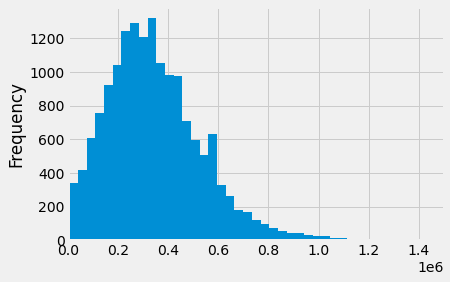

In [ ]:
pd.Series(reg.predict(val.drop(features, axis=1))).plot(kind='hist', bins=100, xlim=(-100, 1.5e6))

0.5255891077021914


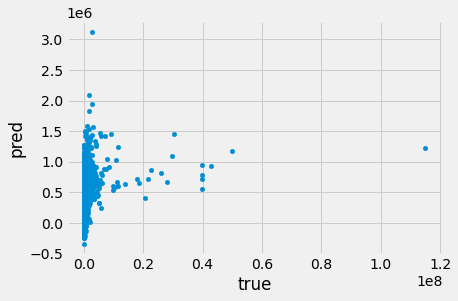

In [ ]:
print(mdape(val.price, reg.predict(val.drop(features, axis=1))))
plot_true_pred(val[['price']].reset_index(drop=True),
            pd.Series(reg.predict(val.drop(features, axis=1))))

## Keras

In [ ]:
!pip install --upgrade tensorflow-probability

     |████████████████████████████████| 4.8 MB 20.5 MB/s 
     |████████████████████████████████| 294 kB 73.9 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler

In [ ]:
def preprocess_total(df, df_test):
    df, df_test = df.copy(), df_test.copy()
    features_cat, features_num = preprocess_main(df)
    _ = preprocess_main(df_test)
    df_test['price'] = np.nan

    # nans
    df[features_cat], df_test[features_cat] = categorical_to_numerical_features(df, df_test,
                                                                           features_cat)
    # train_size = df.shape[0]
    # data = pd.concat([df, df_test], axis=0)[features_cat]
    # data[features_cat] = data[features_cat].apply(replace_na_on_missing).astype('category')
    # ohe = pd.get_dummies(data[features_cat], drop_first=True)
    # print(ohe.shape)
    # df = pd.concat([df, ohe.iloc[:train_size]], axis=1)
    # df_test = pd.concat([df_test, ohe.iloc[train_size:]], axis=1)
    # df.drop(features_cat,axis=1, inplace=True)
    # df_test.drop(features_cat,axis=1, inplace=True)

    df[features_num] = df[features_num].fillna(0)
    # check nans exist only in unused features
    if df.loc[:, df.isna().sum() != 0]\
                .select_dtypes(exclude=['object', 'string']).shape[1] != 0:
                print('There are nans in data')


    cv_folds = TimeSeriesSplit(n_splits=5)
    cv_idx = list(cv_folds.split(df, df.price))[-1]
    train = df.iloc[cv_idx[0]]
    val = df.iloc[cv_idx[1]]

    f_all = train.drop(['price'], axis=1).select_dtypes(exclude=['object', 'string']).columns
    # display(train[f_all].dtypes)
    ss = StandardScaler().fit(train[f_all])
    train[f_all] = ss.transform(train[f_all])
    val[f_all] = ss.transform(val[f_all])
    df_test[f_all] = ss.transform(df_test[f_all])
    
    return train, val, df_test, features_cat


train, val, test, features_cat = preprocess_total(df, df_test)
features = features_str + features_address #+ ['price']
train.drop(features, axis=1, inplace=True)
val.drop(features, axis=1, inplace=True)


In [ ]:
train.to_csv('train.csv')
val.to_csv(('val.csv'))

In [ ]:
input_size = train.shape[1] - 1 # price 
print(input_size)

model = keras.Sequential()
model.add(keras.Input(shape=(input_size,)))
model.add(layers.Dense(64, activation="relu", name="layer1"))
model.add(layers.Dense(32, activation="relu", name="layer2"))
model.add(layers.Dense(1, name="output"))
model.summary()

34
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 64)                2240      
_________________________________________________________________
layer2 (Dense)               (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def pick_median(arg_tensor):
    the_upper_tensor = tfp.stats.percentile(arg_tensor, 50, interpolation='higher')
    the_lower_tensor = tfp.stats.percentile(arg_tensor, 50, interpolation='lower')

    final_tensor = (the_upper_tensor + the_lower_tensor) / 2

    return final_tensor

def tf_mdape(true, pred):
     return pick_median(tf.abs((true - pred)/(true + EPSILON)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))

model.compile(
    optimizer=keras.optimizers.Adam(0.01), #RMSprop(),  
    loss=keras.losses.MeanAbsoluteError(),
    metrics=[tf_mdape],
)

history = model.fit(train.drop('price', axis=1),
                    train.price,
                    batch_size=64,
                    epochs=30,
                    validation_data=(val.drop('price', axis=1), val.price),
                    )

# history.history

Epoch 1/30
1303/1303 [==============================] - 5s 3ms/step - loss: 235093.7025 - tf_mdape: 0.5896 - val_loss: 179653.2812 - val_tf_mdape: 0.3604
Epoch 2/30
1303/1303 [==============================] - 4s 3ms/step - loss: 178249.9480 - tf_mdape: 0.3504 - val_loss: 178750.4688 - val_tf_mdape: 0.3574
Epoch 3/30
1303/1303 [==============================] - 4s 3ms/step - loss: 168310.6473 - tf_mdape: 0.3529 - val_loss: 177887.8750 - val_tf_mdape: 0.3512
Epoch 4/30
1303/1303 [==============================] - 3s 3ms/step - loss: 184865.0974 - tf_mdape: 0.3455 - val_loss: 176640.9062 - val_tf_mdape: 0.3416
Epoch 5/30
1303/1303 [==============================] - 4s 3ms/step - loss: 177348.2914 - tf_mdape: 0.3390 - val_loss: 175140.3750 - val_tf_mdape: 0.3359
Epoch 6/30
1303/1303 [==============================] - 4s 3ms/step - loss: 174606.5207 - tf_mdape: 0.3345 - val_loss: 174269.7500 - val_tf_mdape: 0.3326
Epoch 7/30
1303/1303 [==============================] - 4s 3ms/step - loss: 

In [ ]:
mdape(val.price.values, preds)

0.259511112795398

(16666,)

<AxesSubplot:xlabel='true', ylabel='pred'>

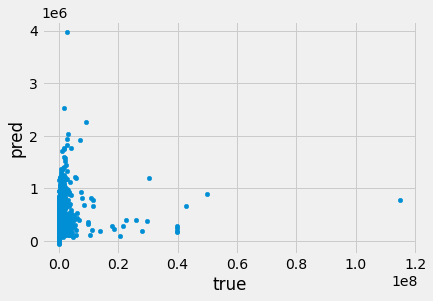

In [ ]:
preds = model.predict(val.drop('price', axis=1)).reshape(-1,)
display(preds.shape)
data = pd.concat([val.price.reset_index(drop=True),
                    pd.Series(preds)], axis=1)
data.columns = ['true', 'pred']
data.plot.scatter(x='true', y='pred')

### Preprocee text features to categorical

In [ ]:
# def find_by_template_and_replace(temp, df, f, name=''):
#     print(f'''rel. % of samples with cyfartalog: \
# {df[f].dropna().str.extract(tmp).notna().sum()/df.shape[0]*100}''')
#     df[name] = df[f].str.extract(tmp).apply(lambda x: np.where(x.isna(), np.nan,x) )
#     display(df[name].dropna().unique())
#     df[name] = df[name].astype('float')
#     df[f] = df[f].str.replace(tmp, '')

In [ ]:
# f = 'epc_walls_description'

# tmp = '\|Trawsyriannedd thermol cyfartalog =*\s*(\d.*\d*) W/m.*K'
# find_by_template_and_replace(tmp, df, f, 'wall_cyfartalog')
# tmp = 'transmittance =*\s*(\d.*\d*) W/m.*K'
# find_by_template_and_replace(tmp, df, f, 'wall_transmittance')

In [ ]:
# temp = df[f].str.replace('+', ',').str.replace('.', ',').str.replace(', ',',')\
#             .str.split(',', expand=True)
# print(f'% of nan is each col\n{temp.notna().sum(axis=0)/temp.shape[0]*100}')
# temp = temp.iloc[:,:7].apply(replace_na_on_missing).astype('category')
# temp.columns = f + temp.columns.astype('string')
# df = pd.concat((df, temp), axis=1)
# features_cat.extend(temp.columns)
# gc.collect();

In [ ]:
# f = 'epc_roof_description'
# tmp = '(\d+)\+*\s*mm loft '
# find_by_template_and_replace(temp, df, f, 'roof_loft')
# tmp = '\|Trawsyriannedd thermol cyfartalog \d.\d\d'
# df[f] = df[f].str.replace(tmp, '')
# tmp = 'transmittance =*\s*(\d\.*\d*) W/m.*K'
# find_by_template_and_replace(temp, df, f, 'roof_transmittance')


In [ ]:
# temp = df[f].str.replace('+', ',').str.replace('.', ',').str.replace(', ',',')\
#             .str.split(',', expand=True)
# print(f'% of nan is each col\n{temp.notna().sum(axis=0)/temp.shape[0]*100}')
# temp = temp.iloc[:,:5].apply(replace_na_on_missing).astype('category')
# temp.columns = f + temp.columns.astype('string')
# df = pd.concat((df, temp), axis=1)
# features_cat.extend(temp.columns)
# gc.collect();

In [ ]:
# f = 'epc_windows_description'
# df[f] = df[[f]].apply(replace_na_on_missing).values
# features_cat.append(f)
# # features_str.remove(f)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=93dfd834-f8d5-41c6-9de5-c4f79b8a1815' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>